In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sqlite3
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [440]:
video_Game = pd.read_csv("vgsales.csv")
print(video_Game.describe())
print(len(video_Game))

               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  
count  16598.000000  
mean       0.048063  
std        0.188588  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        0.040000  
max       10.570000  
16598


### 2. Data Wrangling and Cleaning

In [443]:
##Pre-Processing
missing_data = video_Game.isnull().sum() / len(video_Game) * 100
print(missing_data)

Rank           0.000000
Name           0.000000
Platform       0.000000
Year           1.632727
Genre          0.000000
Publisher      0.349440
NA_Sales       0.000000
EU_Sales       0.000000
JP_Sales       0.000000
Other_Sales    0.000000
dtype: float64


In [445]:
#Deleting Empty values, as year and Publisher can't be filled by imputation or KNN Regression
video_Game_Modified=video_Game.dropna()
print(len(video_Game_Modified))

16291


##### The columns 'Year' and 'Publisher' are categorical and play a crucial role in understanding sales trends. Imputing missing values with methods like mean or regression is not suitable as these methods assume continuous data relationships, which do not apply to categories. Removing rows with missing values ensures the dataset remains consistent and reliable for analysis.

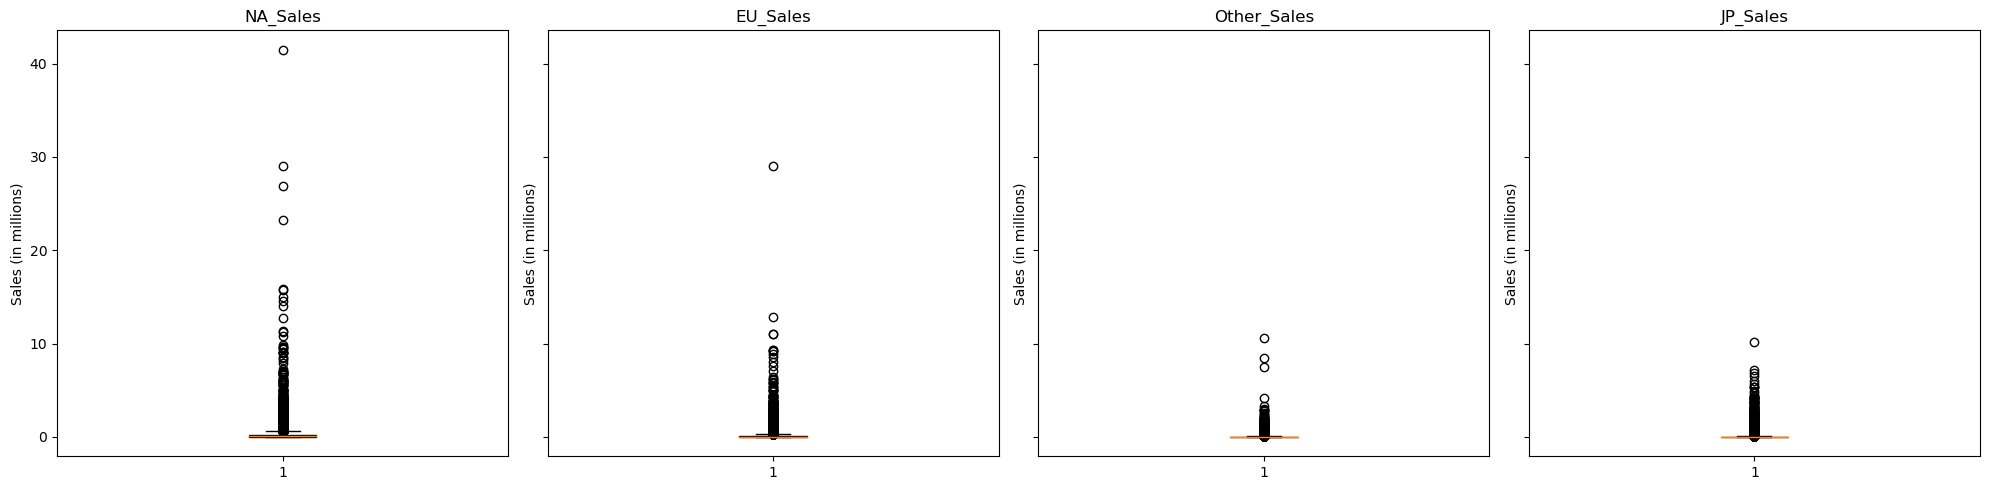

16281


In [447]:
##Outlier Detection and Removal
sales_columns = ['NA_Sales', 'EU_Sales','Other_Sales','JP_Sales']
fig, axes = plt.subplots(nrows=1, ncols=len(sales_columns), figsize=(20, 5), sharey=True)

for i, column in enumerate(sales_columns):
    axes[i].boxplot(video_Game_Modified[column], vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    axes[i].set_title(column)
    axes[i].set_ylabel("Sales (in millions)")

plt.tight_layout()
plt.show()

thresholds = {
    'NA_Sales': 20,
    'EU_Sales': 10,
    'Other_Sales': 5,
    'JP_Sales': 9}

for column, max_value in thresholds.items():
    video_Game_Modified = video_Game_Modified[video_Game_Modified[column] <= max_value]

print(len(video_Game_Modified))

In [448]:
#Datatype consistency check
print(video_Game.dtypes)
#Convert year to int
video_Game_Modified['Year'] = video_Game_Modified['Year'].astype(int)

# Convert columns to categorical
categorical_columns = ['Platform', 'Genre', 'Publisher']
for column in categorical_columns:
    video_Game_Modified[column] = video_Game_Modified[column].astype('category')

# Create LabelEncoder for categorical columns
label_encoder_genre = LabelEncoder()
label_encoder_publisher = LabelEncoder()
label_encoder_platform = LabelEncoder()

# Label encoding
video_Game_Modified['Genre_Label'] = label_encoder_genre.fit_transform(video_Game_Modified['Genre'])
video_Game_Modified['Publisher_Label'] = label_encoder_publisher.fit_transform(video_Game_Modified['Publisher'])
video_Game_Modified['Platform_Label'] = label_encoder_platform.fit_transform(video_Game_Modified['Platform'])

# Keep track of the original mappings for later decoding
genre_mapping = dict(zip(label_encoder_genre.classes_, label_encoder_genre.transform(label_encoder_genre.classes_)))
publisher_mapping = dict(zip(label_encoder_publisher.classes_, label_encoder_publisher.transform(label_encoder_publisher.classes_)))
platform_mapping = dict(zip(label_encoder_platform.classes_, label_encoder_platform.transform(label_encoder_platform.classes_)))

print("Updated DataFrame:")
print(video_Game_Modified.head())

Rank             int64
Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object
Updated DataFrame:
    Rank                         Name Platform  Year         Genre Publisher  \
6      7        New Super Mario Bros.       DS  2006      Platform  Nintendo   
7      8                     Wii Play      Wii  2006          Misc  Nintendo   
8      9    New Super Mario Bros. Wii      Wii  2009      Platform  Nintendo   
11    12                Mario Kart DS       DS  2005        Racing  Nintendo   
12    13  Pokemon Gold/Pokemon Silver       GB  1999  Role-Playing  Nintendo   

    NA_Sales  EU_Sales  JP_Sales  Other_Sales  Genre_Label  Publisher_Label  \
6      11.38      9.23      6.50         2.90            4              359   
7      14.03      9.20      2.93         2.85            3              359   
8      14.59      7

In [449]:
#Feature Engineering
video_Game_Modified['Global_Sales'] = video_Game_Modified[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)

correlation_matrix = video_Game_Modified[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

#Removing JP_sales as it has less correlation index
video_Game_Modified = video_Game_Modified.drop(columns=['JP_Sales'])

Correlation Matrix:               NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
NA_Sales      1.000000  0.769424  0.401048     0.675957      0.929828
EU_Sales      0.769424  1.000000  0.400182     0.812408      0.906610
JP_Sales      0.401048  0.400182  1.000000     0.292702      0.600518
Other_Sales   0.675957  0.812408  0.292702     1.000000      0.792721
Global_Sales  0.929828  0.906610  0.600518     0.792721      1.000000


##### Adding the `Global_Sales` column makes it easier to analyze and model total sales by consolidating sales data from all regions (`NA_Sales`, `EU_Sales`, `JP_Sales`, and `Other_Sales`). This column provides a clear, unified target variable for predictions, ensuring the model focuses on the overall performance rather than fragmented regional data. It simplifies calculations and improves the interpretability of the results.

### 3. SQL Database Design and Querying

In [454]:
# creating tables
genre_table = video_Game_Modified[['Genre']].drop_duplicates().reset_index(drop=True)
genre_table['Genre_ID'] = genre_table.index + 1

publisher_table = video_Game_Modified[['Publisher']].drop_duplicates().reset_index(drop=True)
publisher_table['Publisher_ID'] = publisher_table.index + 1 

platform_table = video_Game_Modified[['Platform']].drop_duplicates().reset_index(drop=True)
platform_table['Platform_ID'] = platform_table.index + 1

video_Game_Modified['Genre'] = label_encoder_genre.inverse_transform(video_Game_Modified['Genre_Label'])
video_Game_Modified['Publisher'] = label_encoder_publisher.inverse_transform(video_Game_Modified['Publisher_Label'])
video_Game_Modified['Platform'] = label_encoder_platform.inverse_transform(video_Game_Modified['Platform_Label'])

video_Game_Modified['Sales_ID'] = video_Game_Modified.index + 1
sales_table = video_Game_Modified[['Sales_ID', 'NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales']]

video_Game_Modified = video_Game_Modified.merge(genre_table, on='Genre').merge(publisher_table, on='Publisher').merge(platform_table, on='Platform')

video_game_table = video_Game_Modified[['Name', 'Year', 'Genre_ID', 'Publisher_ID', 'Platform_ID', 'Sales_ID']]

# downloading to csv files
genre_table.to_csv('genre_table.csv', index=False)
publisher_table.to_csv('publisher_table.csv', index=False)
platform_table.to_csv('platform_table.csv', index=False)
video_game_table.to_csv('video_game_table.csv', index=False)
sales_table.to_csv('sales_table.csv', index=False)

In [456]:
#SQL
conn = sqlite3.connect('video_game.db')
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS genre_table (
    Genre_ID INTEGER PRIMARY KEY,
    Genre TEXT NOT NULL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS publisher_table (
    Publisher_ID INTEGER PRIMARY KEY,
    Publisher TEXT NOT NULL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS platform_table (
    Platform_ID INTEGER PRIMARY KEY,
    Platform TEXT NOT NULL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS sales_table (
    Sales_ID INTEGER PRIMARY KEY,
    NA_Sales REAL,
    EU_Sales REAL,
    Other_Sales REAL,
    Global_Sales REAL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS video_game_table (
    Rank INTEGER,
    Name TEXT NOT NULL,
    Year INTEGER,
    Genre_ID INTEGER,
    Publisher_ID INTEGER,
    Platform_ID INTEGER,
    Sales_ID INTEGER,
    FOREIGN KEY (Genre_ID) REFERENCES genre_table (Genre_ID),
    FOREIGN KEY (Publisher_ID) REFERENCES publisher_table (Publisher_ID),
    FOREIGN KEY (Platform_ID) REFERENCES platform_table (Platform_ID),
    FOREIGN KEY (Sales_ID) REFERENCES sales_table (Sales_ID)
);
''')

conn.commit()

# Importing data from csv file to tables
genre_df = pd.read_csv('genre_table.csv')
publisher_df = pd.read_csv('publisher_table.csv')
platform_df = pd.read_csv('platform_table.csv')
sales_df = pd.read_csv('sales_table.csv')
video_game_df = pd.read_csv('video_game_table.csv')

genre_df.to_sql('genre_table', conn, if_exists='replace', index=False)
publisher_df.to_sql('publisher_table', conn, if_exists='replace', index=False)
platform_df.to_sql('platform_table', conn, if_exists='replace', index=False)
sales_df.to_sql('sales_table', conn, if_exists='replace', index=False)
video_game_df.to_sql('video_game_table', conn, if_exists='replace', index=False)

conn.commit()
conn.close()

##### This code splits my video game data into separate tables for genres, publishers, platforms, and sales, giving each a unique ID to keep things organized. It saves these tables as CSV files and uploads them into a SQLite database, linking them together using relationships. This makes the data easier to manage, reduces duplication, and allows me to run efficient queries for analysis.

In [457]:
#Checking the data which is inserted
conn = sqlite3.connect('video_game.db')
cursor = conn.cursor()
cursor.execute("SELECT * FROM genre_table")
rows = cursor.fetchall()
for row in rows:
    print(row)
conn.close()

('Platform', 1)
('Misc', 2)
('Racing', 3)
('Role-Playing', 4)
('Sports', 5)
('Action', 6)
('Puzzle', 7)
('Shooter', 8)
('Fighting', 9)
('Simulation', 10)
('Adventure', 11)
('Strategy', 12)


### 4. Exploratory Data Analysis (EDA)

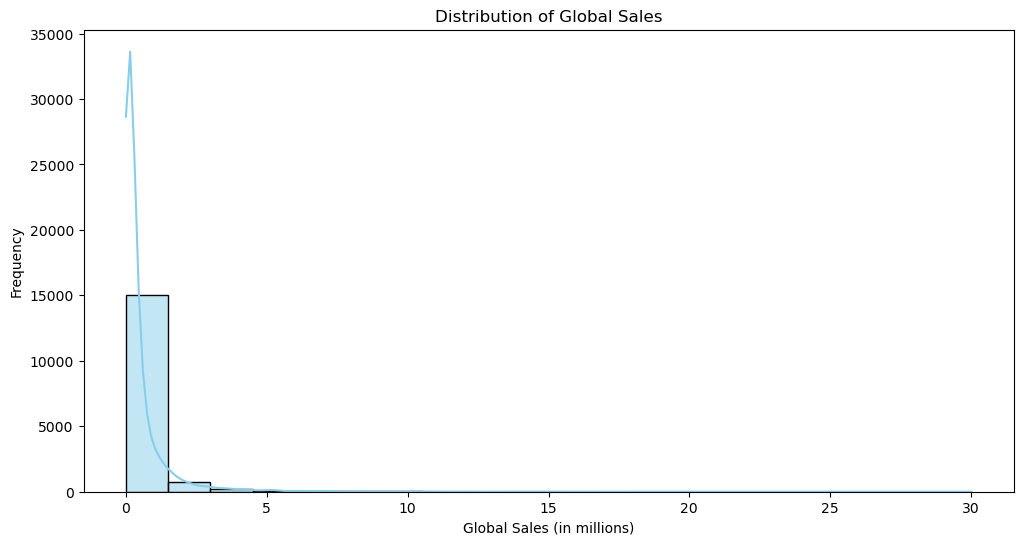

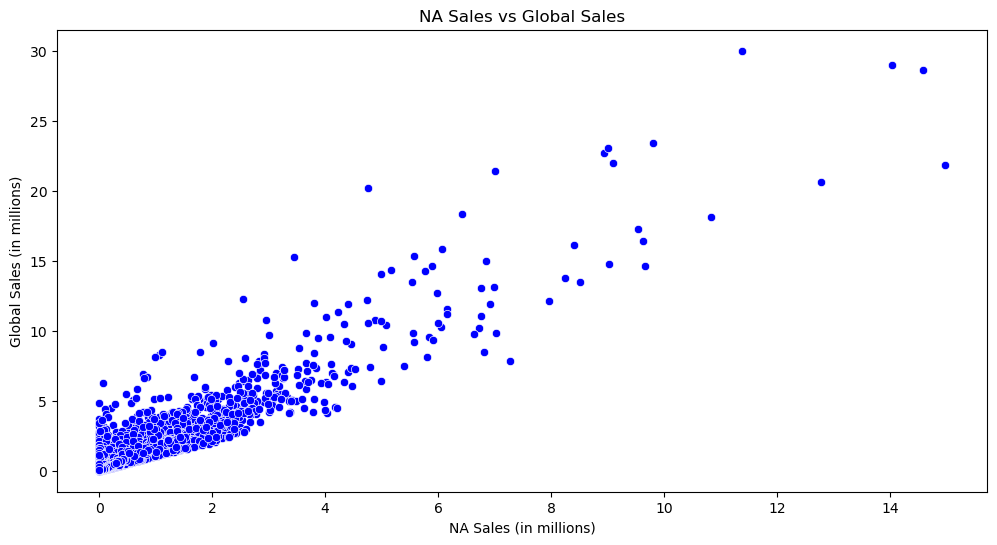

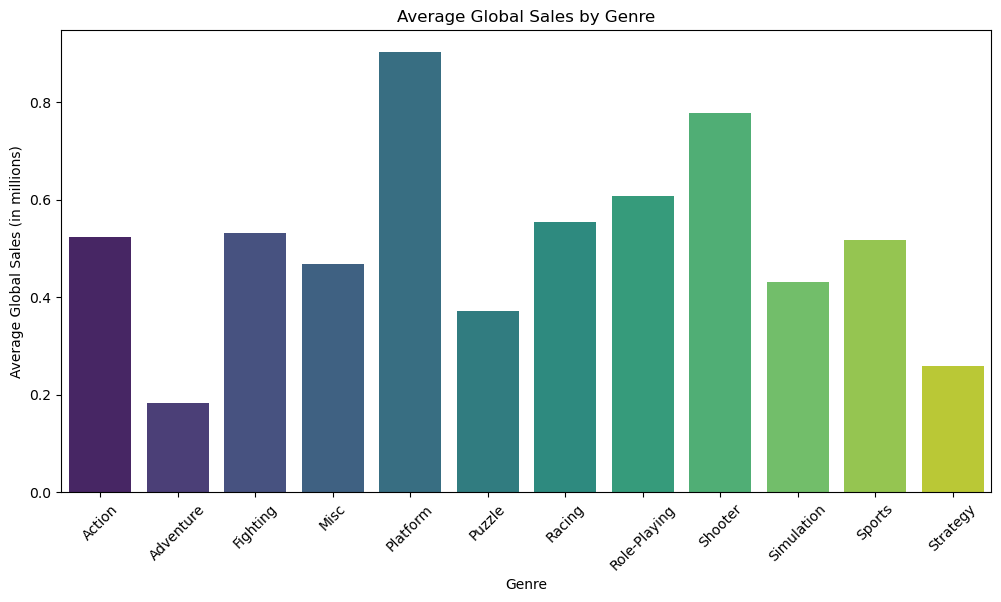

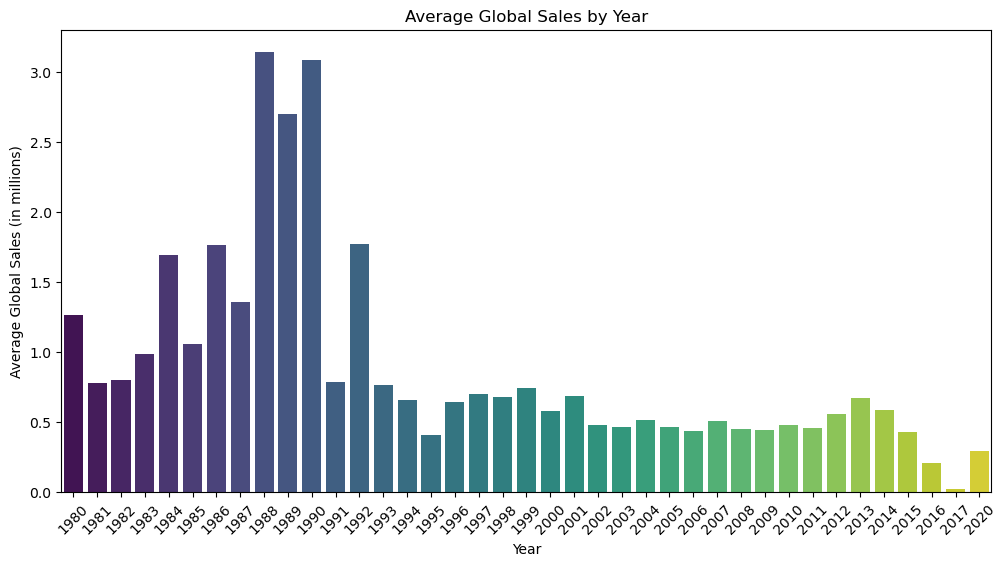

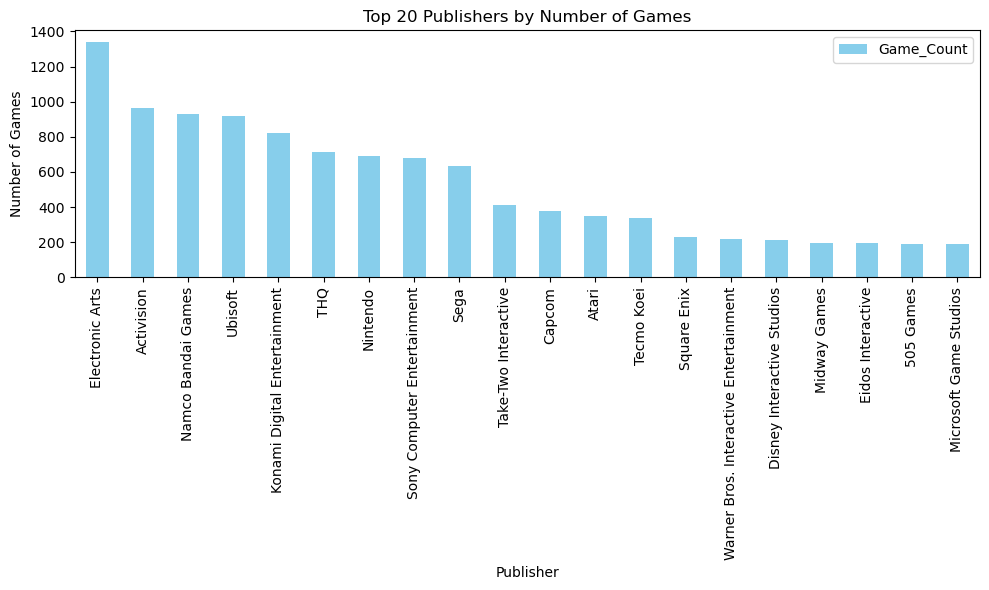

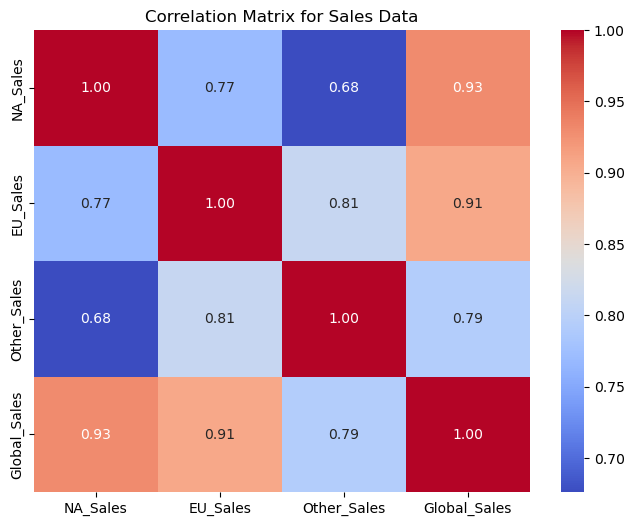

C:\Users\mahes\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


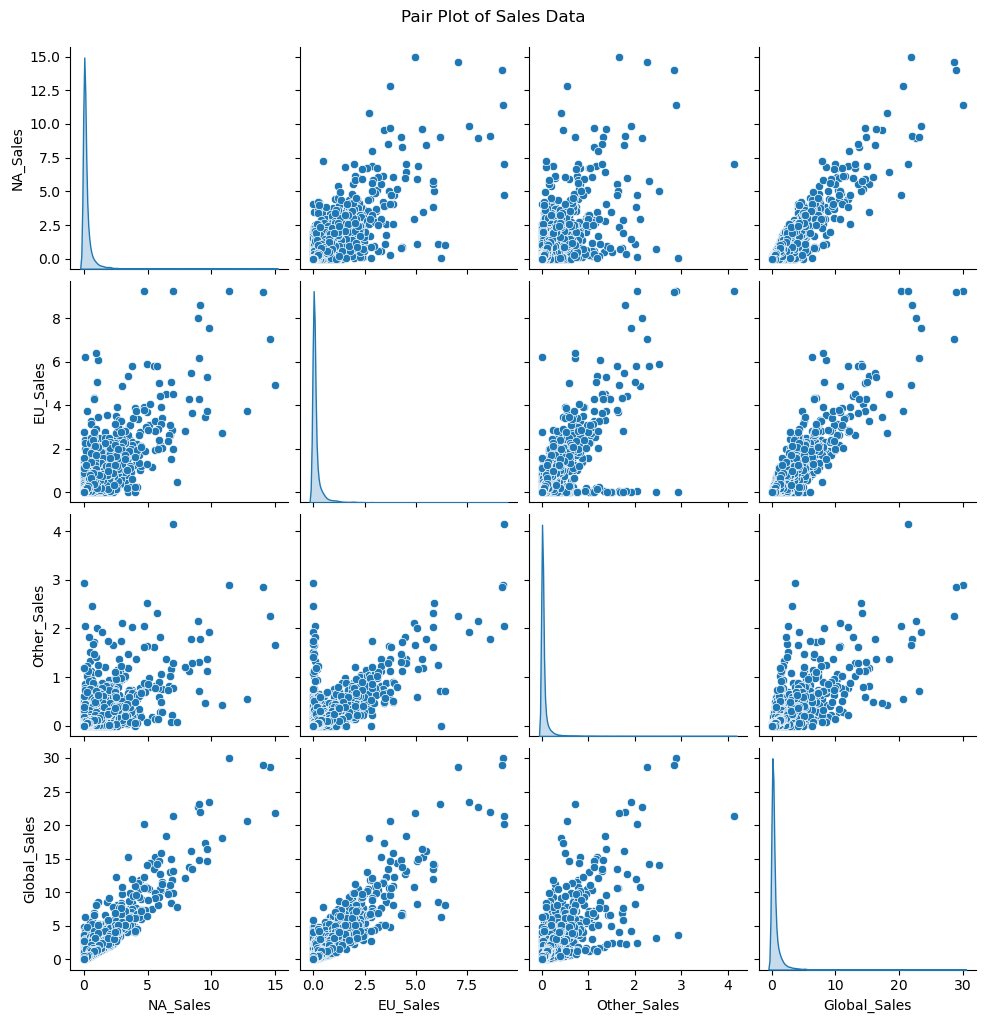

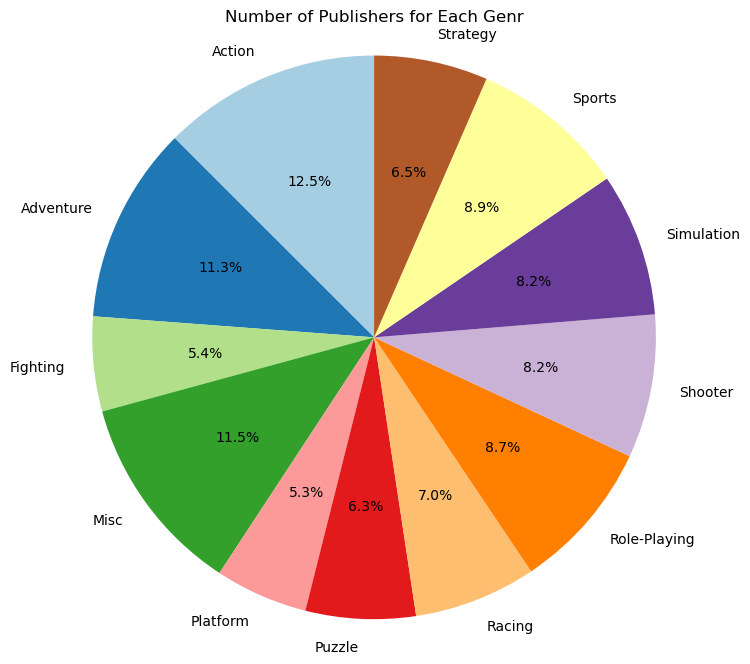

Correlation Coefficients:
              NA_Sales  EU_Sales  Other_Sales  Global_Sales
NA_Sales      1.000000  0.769424     0.675957      0.929828
EU_Sales      0.769424  1.000000     0.812408      0.906610
Other_Sales   0.675957  0.812408     1.000000      0.792721
Global_Sales  0.929828  0.906610     0.792721      1.000000
NA Sales Variance: 0.39784833878727943
NA Sales Standard Deviation: 0.630752200778784
EU Sales Variance: 0.1781704621921542
EU Sales Standard Deviation: 0.42210243092424166
Other Sales Variance: 0.019825652450282193
Other Sales Standard Deviation: 0.14080359530311076
Global Sales Variance: 1.57610965216913
Global Sales Standard Deviation: 1.2554320579661529


In [461]:
conn = sqlite3.connect('video_game.db')
cursor = conn.cursor()

# Data Retrieval from the Database
query = '''
SELECT vg.Name, vg.Year, s.NA_Sales, s.EU_Sales, s.Other_Sales, s.Global_Sales, g.Genre, p.Publisher, pl.Platform
FROM video_game_table vg
JOIN sales_table s ON vg.Sales_ID = s.Sales_ID
JOIN genre_table g ON vg.Genre_ID = g.Genre_ID
JOIN publisher_table p ON vg.Publisher_ID = p.Publisher_ID
JOIN platform_table pl ON vg.Platform_ID = pl.Platform_ID
'''
data = pd.read_sql_query(query, conn)

# Univariate Analysis 
# Histogram for Global Sales
plt.figure(figsize=(12, 6))
sns.histplot(data['Global_Sales'], kde=True, color='skyblue', bins=20)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Frequency')
plt.show()

# Bivariate Analysis
# Scatter plot for NA Sales vs Global Sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data['NA_Sales'], y=data['Global_Sales'], color='blue')
plt.title('NA Sales vs Global Sales')
plt.xlabel('NA Sales (in millions)')
plt.ylabel('Global Sales (in millions)')
plt.show()

# Bar Plots
# Bar plot of average global sales by Genre
plt.figure(figsize=(12, 6))
avg_sales_by_genre = data.groupby('Genre')['Global_Sales'].mean().reset_index()
sns.barplot(x='Genre', y='Global_Sales', data=avg_sales_by_genre, palette='viridis')
plt.title('Average Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Bar plot of average global sales by Year
plt.figure(figsize=(12, 6))
avg_sales_by_year = data.groupby('Year')['Global_Sales'].mean().reset_index()
sns.barplot(x='Year', y='Global_Sales', data=avg_sales_by_year, palette='viridis')
plt.title('Average Global Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Top N Publishers (Bar Plot)
query_top_publishers = '''
SELECT p.Publisher, COUNT(*) AS Game_Count
FROM video_game_table v
JOIN publisher_table p ON v.Publisher_ID = p.Publisher_ID
GROUP BY p.Publisher
ORDER BY Game_Count DESC
LIMIT 20;
'''
top_publishers = pd.read_sql(query_top_publishers, conn)
top_publishers.plot(kind='bar', x='Publisher', y='Game_Count', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Publishers by Number of Games')
plt.xlabel('Publisher')
plt.ylabel('Number of Games')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Multivariate Analysis
# Correlation heatmap
corr_matrix = data[['NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Sales Data')
plt.show()

# Pair plots
sns.pairplot(data[['NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales']], diag_kind='kde')
plt.suptitle('Pair Plot of Sales Data', y=1.02)
plt.show()

# Pie chart
query = '''
SELECT g.Genre, COUNT(DISTINCT p.Publisher) AS Publisher_Count
FROM video_game_table vgt
JOIN genre_table g ON vgt.Genre_ID = g.Genre_ID
JOIN publisher_table p ON vgt.Publisher_ID = p.Publisher_ID
GROUP BY g.Genre
'''
plt.figure(figsize=(8, 8))
plt.pie(df['Publisher_Count'], labels=df['Genre'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Number of Publishers for Each Genr')
plt.axis('equal')
plt.show()

# Statistical Metrics
# Correlation coefficients
correlation = data[['NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales']].corr()
print("Correlation Coefficients:")
print(correlation)

# Variance and standard deviation for sales
na_sales_variance = data['NA_Sales'].var()
na_sales_std = data['NA_Sales'].std()
print(f"NA Sales Variance: {na_sales_variance}")
print(f"NA Sales Standard Deviation: {na_sales_std}")

eu_sales_variance = data['EU_Sales'].var()
eu_sales_std = data['EU_Sales'].std()
print(f"EU Sales Variance: {eu_sales_variance}")
print(f"EU Sales Standard Deviation: {eu_sales_std}")

other_sales_variance = data['Other_Sales'].var()
other_sales_std = data['Other_Sales'].std()
print(f"Other Sales Variance: {other_sales_variance}")
print(f"Other Sales Standard Deviation: {other_sales_std}")

global_sales_variance = data['Global_Sales'].var()
global_sales_std = data['Global_Sales'].std()
print(f"Global Sales Variance: {global_sales_variance}")
print(f"Global Sales Standard Deviation: {global_sales_std}")

conn.close()


### 5. Advanced Data Analysis with Machine Learning

In [463]:
X = video_Game_Modified[['NA_Sales', 'EU_Sales', 'Other_Sales', 'Genre_Label', 'Publisher_Label', 'Platform_Label']]
y = video_Game_Modified['Global_Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store model results
results = {}

# 1. Chi-Square Test
chi2_data = pd.crosstab(video_Game_Modified['Genre_Label'], video_Game_Modified['Publisher_Label'])
chi2, p, dof, expected = chi2_contingency(chi2_data)
results['Chi-Square Test'] = {
    'Chi2': chi2,
    'p-value': p
}


# 2. ANOVA test for Global Sales with Genre and Publisher
anova_genre = f_oneway(*[data['Global_Sales'][data['Genre'] == g] for g in data['Genre'].unique()])
anova_publisher = f_oneway(*[data['Global_Sales'][data['Publisher'] == p] for p in data['Publisher'].unique()])

results['ANOVA (Genre)'] = {
    'F-statistic': anova_genre.statistic,
    'p-value': anova_genre.pvalue
}

results['ANOVA (Publisher)'] = {
    'F-statistic': anova_publisher.statistic,
    'p-value': anova_publisher.pvalue
}


# 3. Multiple Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}

# 4. Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results['Gradient Boosting'] = {
    'MSE': mean_squared_error(y_test, y_pred_gb),
    'R2': r2_score(y_test, y_pred_gb)
}

# 5. Decision Tree
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
results['Decision Tree'] = {
    'MSE': mean_squared_error(y_test, y_pred_dt),
    'R2': r2_score(y_test, y_pred_dt)
}

# 6. SVR Regression
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
results['SVM'] = {
    'MSE': mean_squared_error(y_test, y_pred_svr),
    'R2': r2_score(y_test, y_pred_svr)
}

# 7. KNN Regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results['KNN'] = {
    'MSE': mean_squared_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn)
}

for model, metrics in results.items():
    print(f"{model}: {metrics}\n")


Chi-Square Test: {'Chi2': 25256.16200511597, 'p-value': 0.0}

ANOVA (Genre): {'F-statistic': 25.79536890149485, 'p-value': 7.26613592474901e-54}

ANOVA (Publisher): {'F-statistic': 4.037979132071412, 'p-value': 7.835666340476773e-189}

Linear Regression: {'MSE': 0.08218054224308385, 'R2': 0.9566272852555614}

Gradient Boosting: {'MSE': 0.06630001289258013, 'R2': 0.9650086082635396}

Decision Tree: {'MSE': 0.14368885262105396, 'R2': 0.9241648272622204}

SVM: {'MSE': 1.9327686272598013, 'R2': -0.02006411796576435}

KNN: {'MSE': 0.4022991860798362, 'R2': 0.787677139095185}



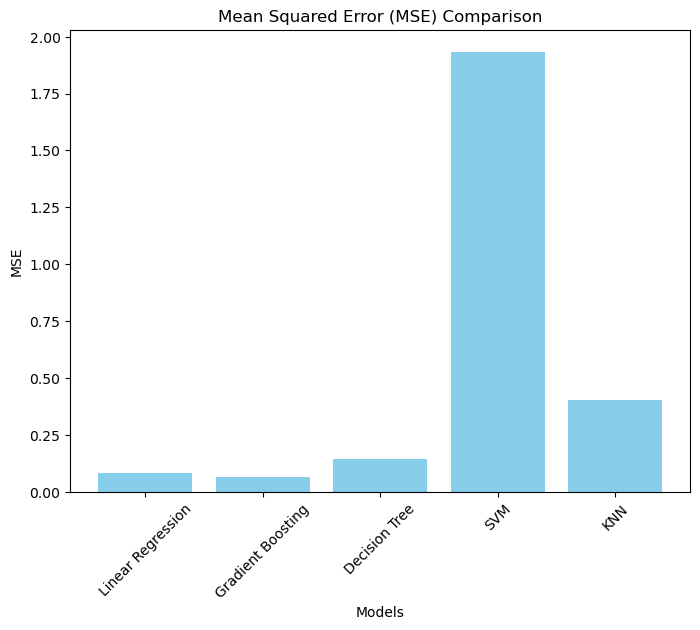

In [464]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for all models
mse_scores = {
    'Linear Regression': mean_squared_error(y_test, y_pred_lr),
    'Gradient Boosting': mean_squared_error(y_test, y_pred_gb),
    'Decision Tree': mean_squared_error(y_test, y_pred_dt),
    'SVM': mean_squared_error(y_test, y_pred_svr),
    'KNN': mean_squared_error(y_test, y_pred_knn)
}

# Plot MSE comparison
plt.figure(figsize=(8, 6))
plt.bar(mse_scores.keys(), mse_scores.values(), color='skyblue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.ylabel('MSE')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()


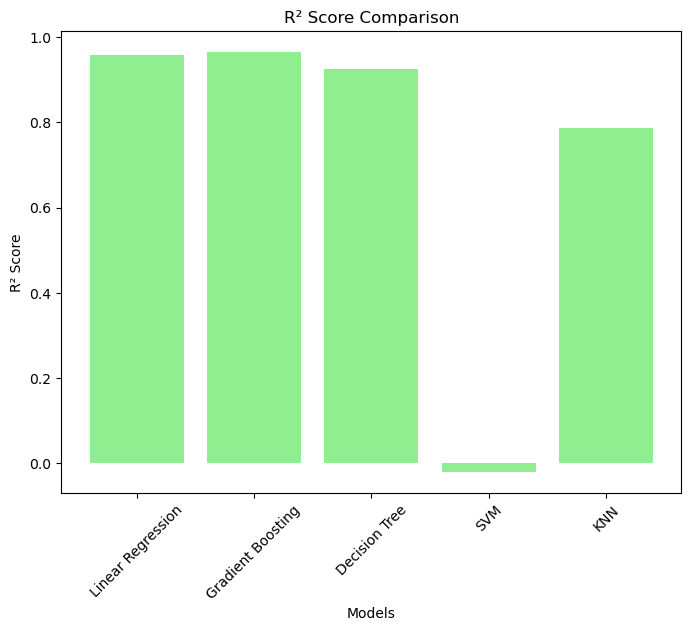

In [465]:
# Calculate R² scores for all models
r2_scores = {
    'Linear Regression': r2_score(y_test, y_pred_lr),
    'Gradient Boosting': r2_score(y_test, y_pred_gb),
    'Decision Tree': r2_score(y_test, y_pred_dt),
    'SVM': r2_score(y_test, y_pred_svr),
    'KNN': r2_score(y_test, y_pred_knn)
}

# Plot R² comparison
plt.figure(figsize=(8, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color='lightgreen')
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()


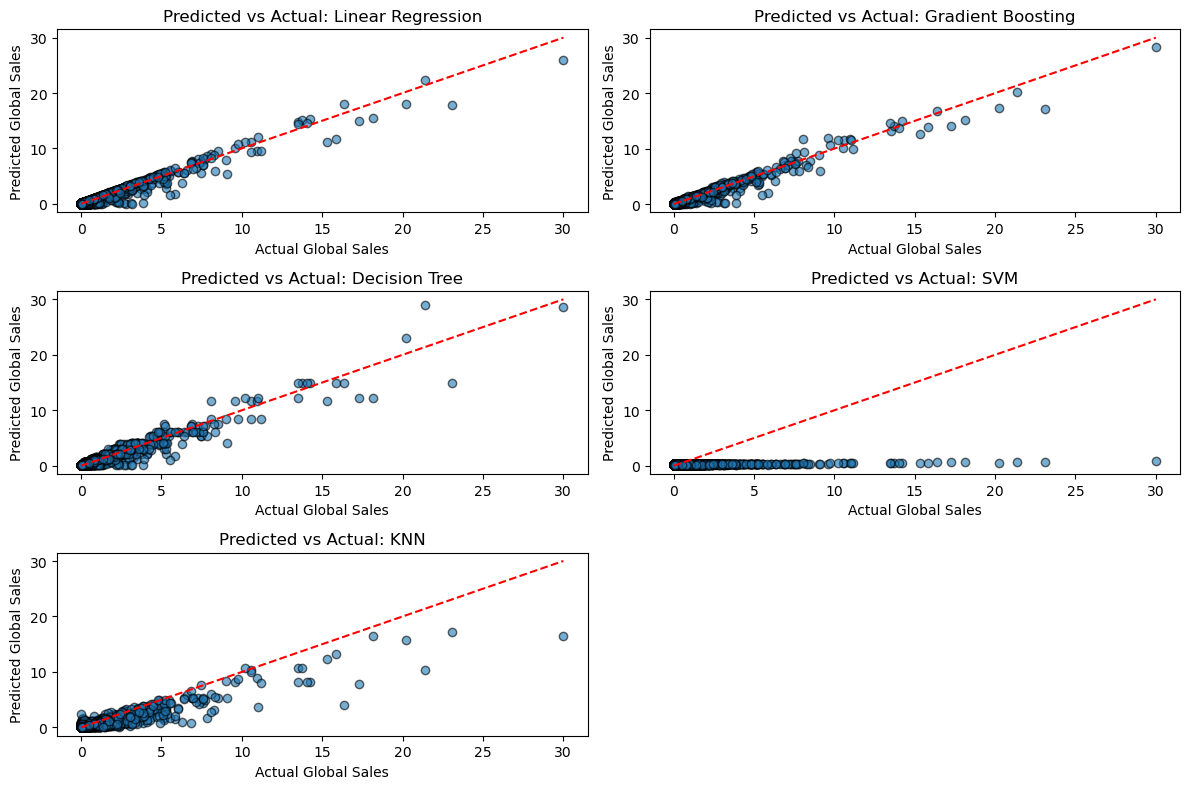

In [466]:
# Predicted values from the models
models = {
    'Linear Regression': y_pred_lr,
    'Gradient Boosting': y_pred_gb,
    'Decision Tree': y_pred_dt,
    'SVM': y_pred_svr,
    'KNN': y_pred_knn
}

# Scatter plot for predicted vs actual
plt.figure(figsize=(12, 8))
for i, (model_name, y_pred) in enumerate(models.items()):
    plt.subplot(3, 2, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f"Predicted vs Actual: {model_name}")
    plt.xlabel("Actual Global Sales")
    plt.ylabel("Predicted Global Sales")
plt.tight_layout()
plt.show()


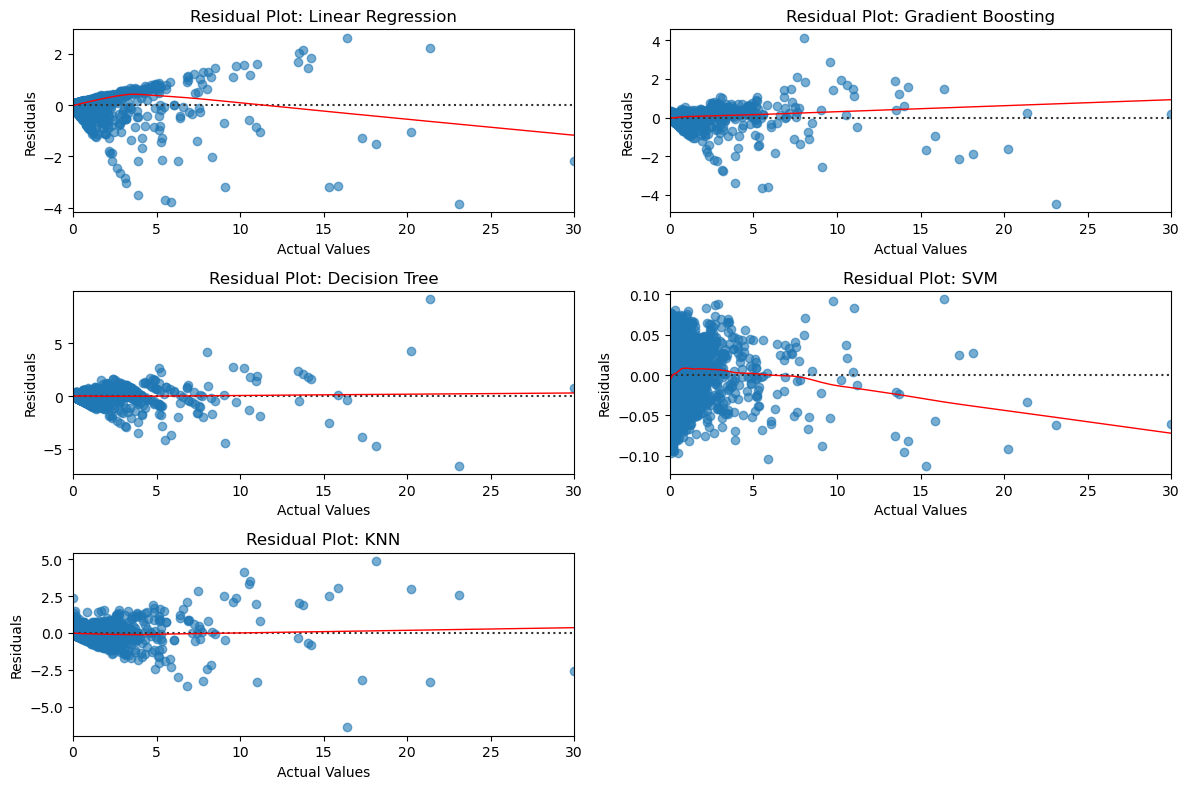

In [467]:
# Residual plots for each model
plt.figure(figsize=(12, 8))
for i, (model_name, y_pred) in enumerate(models.items()):
    plt.subplot(3, 2, i + 1)
    sns.residplot(x=y_test, y=y_pred - y_test, lowess=True, line_kws={'color': 'red', 'lw': 1}, scatter_kws={'alpha': 0.6})
    plt.title(f"Residual Plot: {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


### 1. Chi-Square Test
The Chi-Square test showed a strong link between game genres and publishers, meaning certain publishers tend to specialize in specific genres. This pattern likely reflects their strengths or audience preferences.

### 2. ANOVA
ANOVA revealed that genres and publishers both impact sales, with genres having a bigger effect. This highlights that the type of game is more important for sales than who publishes it.

### 3. Multiple Linear Regression
Linear regression explained 95.6% of the sales variation, with accurate predictions (MSE: 0.082). It's a simple and effective model for understanding and predicting sales.

### 4. Gradient Boosting Regressor
Gradient Boosting was the most accurate model, with the lowest error (MSE: 0.066) and the highest ability to explain sales trends (R²: 0.965). It’s ideal for capturing detailed patterns in the data.

### 5. Decision Tree Regressor
The Decision Tree performed well (MSE: 0.144, R²: 0.924) but wasn’t as strong as Gradient Boosting or Linear Regression. It works better for simpler tasks or quick interpretations.

### 6. Support Vector Regressor (SVM)
SVM didn’t work well for this task, showing poor predictions (MSE: 1.933, R²: -0.02). This model struggles with the dataset's complexity and is not suitable here.

### 7. K-Nearest Neighbors (KNN)
KNN had moderate results (MSE: 0.402, R²: 0.788) but fell short of Gradient Boosting and Linear Regression. It’s less effective at capturing complex patterns.

### Summary
Genres are the main factor driving sales, with publishers playing a smaller role. Gradient Boosting is the best model for predicting sales, while Linear Regression is a reliable backup. These insights can help publishers focus on successful genres and plan for better sales.